# Cooke triplet optimization

This example shows an optimization of the Cooke Triplet presented at this page:

https://wp.optics.arizona.edu/jsasian/wp-content/uploads/sites/33/2016/03/L20_OPTI517_Cooke_triplet.pdf

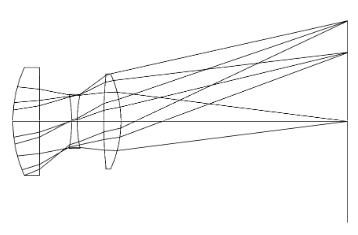

I doubt that it's a bad design. My optimization is likely to show an apparent improvement, but the difference may be due to me guessing at some of the parameters, and also, using the modern "N" glasses, which came out of the re-design of catalog glasses to eliminate lead, cadmium, and some other nasty elements. Virtually all commercial lens designs had to be updated several years ago because the glass makers switched to lead-free catalogs in light of RoHS and other hazardous substance regulations.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

import opticsRayTrace.rayTraceTools as rtt
import opticsRayTrace.drawing as rtd
import opticsRayTrace.optimize as rto
import opticsRayTrace.analyze as rta

rayTraceTools loaded
drawing loaded
optimize loaded
analyze loaded


Variables are added directly to the surface list. This is a useful case of being to expand the surface
"data structure" just by adding a key-value pair. Of course there are pro's and con's to this
approach. While it's a flexible way to quickly add functionality, there is absolutely no checking
for misspelled or missing elements, that would be caught by a compiled language with rigid
field declarations.

In [3]:
surface_list = [
{'surf': 'dummy',
 'dist': 10},

{'surf': 'conic',
  'R': 23.713,
  'dist': 4.831,
  'draw_radius': 10,
  'material': 'N-LAK9',
  'variables': ['R']},

 {'surf': 'conic',
  'R': 7331.288,
  'dist': 5.86,
  'draw_radius': 10,
  'variables': ['R']},

 {'surf': 'conic',
  'R': -24.456,
  'dist': 0.975,
  'draw_radius': 10,
  'material': 'N-SF5',
  'stop': True,
  'variables': ['R']},

 {'surf': 'conic',
  'R': 21.896,
  'dist': 4.822,
  'draw_radius': 10,
  'variables': ['R']},

 {'surf': 'conic',
  'R': 86.759,
  'dist': 3.127,
  'draw_radius': 10,
  'material': 'N-LAK9',
  'variables': ['R']},

 {'surf': 'conic',
  'R': -20.494,
  'dist': 41.10346,
  'draw_radius': 10,
  'variables': ['R']},
  
 {'surf': 'dummy'}
 ]

stop_surface = 4

This is a basic setup for taking a first look at the model. You'll use this over and over, yet there's just
enough flexibility needed, that it doesn't make sense to roll all of this stuff into a library function.

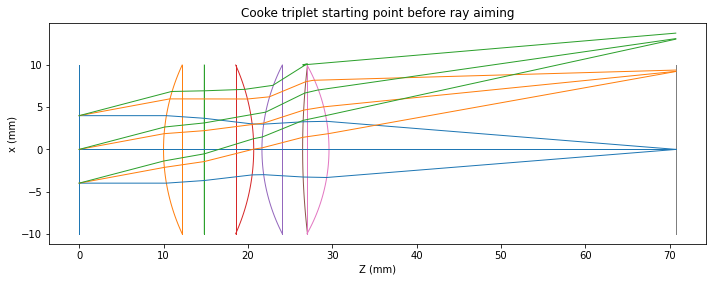

In [4]:
geometry = rtt.build_geometry(surface_list)
wavls = [0.000633]
ray_table = rtt.ray_table_fields_1d(geometry, 15, 3, 8, 3, wavls)
rtt.trace_rays(ray_table, geometry)

# now let's see what we've got

axd = rtd.new_plot(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry, linewidth = 1)
rtd.plot_rays(axd, geometry, ray_table, linewidth = 1, color_by = "field")
axd["axs"][0].set_title("Cooke triplet starting point before ray aiming")
plt.show()

**Problem**: The apparent entrance pupil is at the entrance to the system, not where we want it. In the author's drawing, the beams for the three
fields are all concentric at the middle lens, which is presumably where you'd put a physical aperture in a real lens. A rule that I learned
from an old mentor was: *Always mind your pupils and stops*.

The accepted name for this technique is *ray aiming*. Commercial software packages boast of the sheer number of different ray
aiming methods that you can choose from. For my purposes, I'm happy to have something that works well enough to be useful while
I work on other features.

My ray aiming method applies a linear transformation to the positions of the rays at the entrance surface, shifting them around until
the beams for the fields are all centered at the specified stop surface.

$p'_x = a + (1 + b) p_x + c p_y$

$p'_y = d + e p_x + (1 + f) p_y$

$p'_z = p_z$

The transformation is arranged so that the ray aiming constants $[a, b, c, d, e, f]$ are zero when there is no ray aiming. There
are "cross terms" $c$ and $e$ so that ray aiming still works when there are coordinate rotations along the z-axis
within the system.

After ray aiming, you'll see that the beams from all of the fields cross through one another at the front face
of the concave lens. This could be further improved by putting the stop at a dummy surface to represent
where you could actually insert a hard physical aperture. But, good enough, let's move on. It's beginning to
look like a real lens!

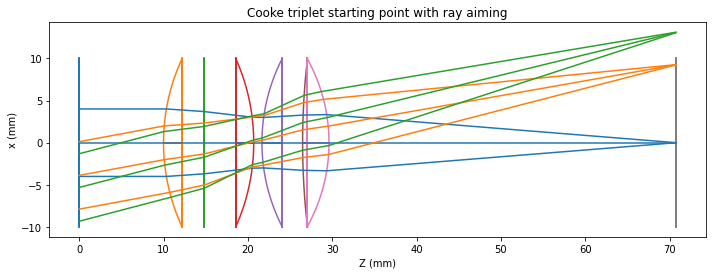

In [5]:
'''
The ray aiming constants are 6 coefficients of a linear transformation applied
to field points. Ray aiming finds values of these coefficients that minimize the
RMS radius of the ray bundle at the stop surface.

A library function sets up a simple merit function, and minimizes it to find
the best values of the ray aiming constants.
'''
aim_consts = rto.ray_aiming(geometry, wavls, True)

'''
Given desired values of the aiming constants, we recompute the starting ray table
and propagate the new rays through the optical system. Note that I haven't
optimized the design yet, but the spot sizes already look smaller. This design
is now closer to the original textbook design.
'''

ray_table = rtt.ray_table_fields_1d(geometry, 15, 3, 8, 3, wavls, aim_consts)

rtt.trace_rays(ray_table, geometry)
axd = rtd.new_plot(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, color_by = 'field')
axd["axs"][0].set_title("Cooke triplet starting point after ray aiming")
plt.show()

One last trimming: I didn't give any radii for drawing the surfaces, and it's hard to visually compare the drawings to the one from the reference, so I created a little script that applies a default to each surface, just big enough to contain the rays, plus a margin. This is purely aesthetic. My program doesn't do anything with the draw radius while ray tracing. It will trace rays that are outside of the draw radius without throwing an error.

optimize loaded


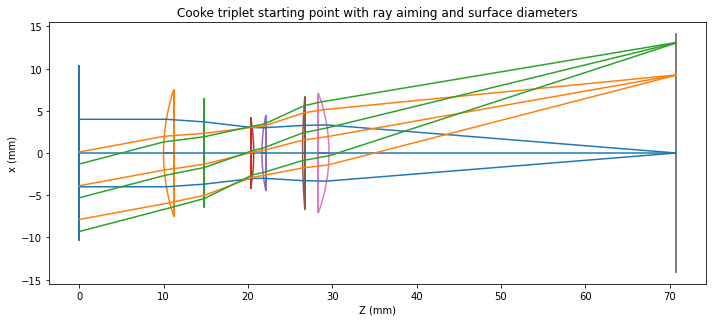

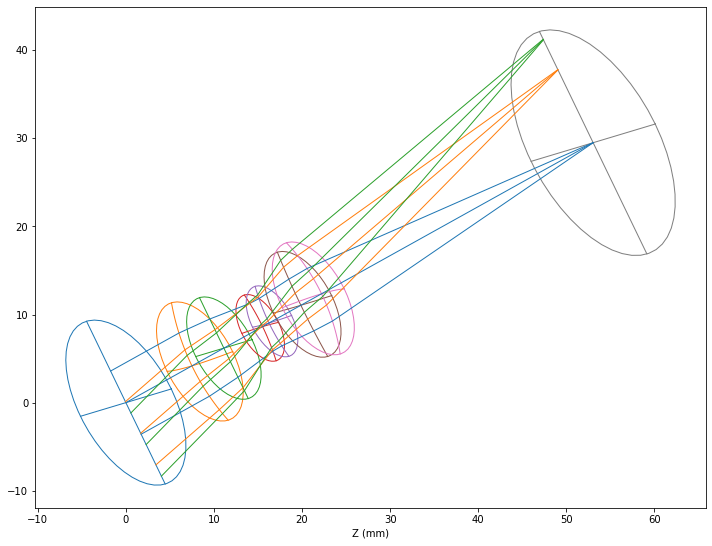

In [6]:
def find_draw_radii(ray_table):
    radius_list = []
    for surf in range(ray_table.shape[0]):
        radius = np.max(np.sqrt(np.sum(ray_table[surf, :, 0, :-1]**2, axis = 1)))
        radius_list.append(radius)
    return np.array(radius_list)

def apply_draw_radii(geometry, ray_table, margin):
    radii = find_draw_radii(ray_table) + margin
    for i in range(len(geometry)):
        geometry[i]['draw_radius'] = radii[i]
        
apply_draw_radii(geometry, ray_table, 1)
        
axd = rtd.new_plot(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, color_by = "field")
axd["axs"][0].set_title("Cooke triplet starting point with ray aiming and surface diameters")
plt.show()

axd = rtd.new_plot(axes = ["3d"], figsize = (10, 10))
rtd.plot_faces(axd, geometry, linewidth = 1)
rtd.plot_rays(axd, geometry, ray_table, linewidth = 1, color_by = "field")
plt.show()

**Now for optimization**. I believe that *optics design comes alive with optimization.* Everything I've done, up to this point, is a series of small steps that got me to the point where I could try out optimization. My reasons is that you can only get so far with design formulas and analyses before you run up against the limits of their accuracy. Optimization sidesteps many of the formulas by working directly with small to large numbers of real rays, traced exactly.

The three inputs to optimization are:

1. The starting point. This is a design that's "close" to having desired performance. You may have arrived at the starting point by adapting textbook designs and formulas, looking up lens patents, and so forth. It's what you see above. 

2. The variable list. This is the list of design parameters that optimization is allowed to vary. There are good reasons for not trying to vary everything. For instance, you might want to stick with the curvatures of lenses that you found in a catalog, and only vary the distances. Also, optimization can find solutions that are not physically realizable, and most often be constrained, a topic for another day.

3. The merit function. This is also called the "loss" or "cost" function in contemporary machine learning jargon. It's a function of the variable parameters, that is expected to be at a minimum when the system has been opimized. Traditionally, optimization *minimizes* something.

I'm going to define a really basic merit function, which will be the sum of RMS spot sizes. For this purpose, the rays have to be separated by field, so that each field gets its own RMS value. The starting parameters are all of the curvatures in the starting point design.

In [11]:
starting_params = rto.get_values(rto.get_variable_list(surface_list))
starting_params

array([  23.713, 7331.288,  -24.456,   21.896,   86.759,  -20.494])

In [12]:
def merit_focus_quality(params, ray_table, surface_list):
    '''
    Compute the merit function.

    Always do a merit_prepare(). This is what inserts the new parameters into the
    surface list, creates a new geometry, and traces the rays. After this function
    runs, the ray table and geometry reflect the new parameters. Here, we don't
    do anything with the geometry, but your merit function could, if you want to
    impose constraints on the design parameters.
    '''
    geometry = rto.merit_prepare(params, ray_table, surface_list)

    '''
    In this case the merit function is the RMS average of the individual RMS
    spot radii for the individual fields. First it gets a list of RMS spot radii
    for the fields, then combines them into a single value.
    '''
    
    rmsa = rta.rms_by_field_radial(ray_table)
    merit = np.sqrt(np.average(rmsa**2))

    return merit


It's useful to note some of the many things that the merit function does not do. *Look up the merit_prepare() function, don't just trust it.* Something I just noticed is that merit_prepare() does not perform ray aiming. It's re-using the aiming constants that were found above. In fact, the optimized design will show a slight leftward shift of the apparent pupil location.

You can take care of this, for instance by optimizing twice, with an intermediate ray aiming step, or rebuilding the ray table each time, at the expense of computation time. Or you could accept the limitations of trying to use a free Python library.

In [13]:
ray_table = rtt.ray_table_fields_rings(geometry, 15, 3, 8, 3, wavls, aim_consts)

In [14]:
result = minimize(merit_focus_quality, starting_params, (ray_table, surface_list))
result['x']

array([  17.95418401, 7331.26774577,  -30.05943085,   17.2403353 ,
        139.55678139,  -31.14563796])

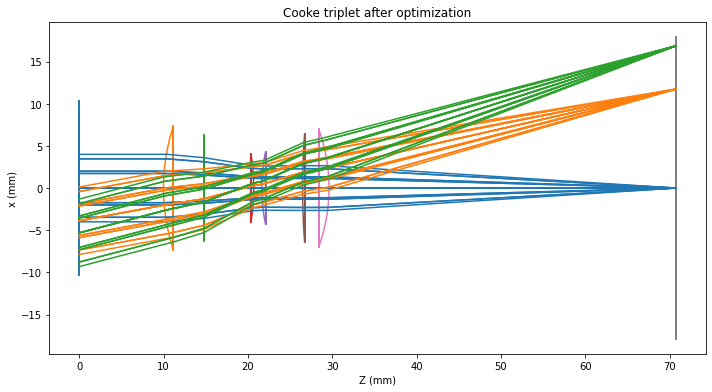

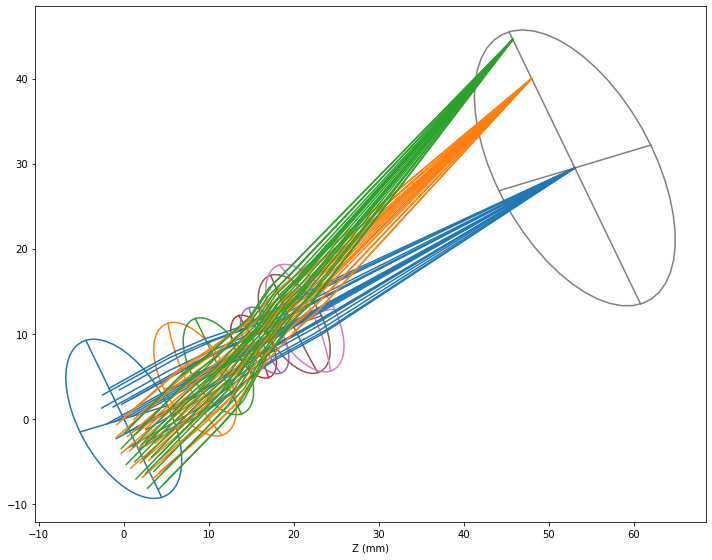

In [15]:
apply_draw_radii(geometry, ray_table, 1)

axd = rtd.new_plot(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, color_by = "field")
axd["axs"][0].set_title("Cooke triplet after optimization")
plt.show()

axd = rtd.new_plot(axes = ["3d"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, color_by = "field")

In [16]:
import cProfile
import pstats

In [17]:
ray_table = rtt.ray_table_fields_rings(geometry, 15, 10, 8, 10, wavls, aim_consts)
cProfile.run('merit_focus_quality(starting_params, ray_table, surface_list)', 'merit_focus_quality_profile')

In [14]:
p = pstats.Stats('merit_focus_quality_profile')
p.sort_stats('cumulative').print_stats(10)

Fri Aug 23 20:57:37 2024    merit_focus_quality_profile

         1610 function calls in 0.018 seconds

   Ordered by: cumulative time
   List reduced from 72 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.018    0.018 {built-in method builtins.exec}
        1    0.000    0.000    0.018    0.018 <string>:1(<module>)
        1    0.000    0.000    0.018    0.018 C:\Users\Spatt\AppData\Local\Temp\ipykernel_14656\3156857341.py:1(merit_focus_quality)
        1    0.000    0.000    0.017    0.017 C:\Users\Spatt\Dropbox\gitRepos\opticsRayTrace\src\opticsRayTrace\optimize.py:56(merit_prepare)
        1    0.000    0.000    0.017    0.017 C:\Users\Spatt\Dropbox\gitRepos\opticsRayTrace\src\opticsRayTrace\rayTraceTools.py:666(trace_rays)
        6    0.004    0.001    0.016    0.003 C:\Users\Spatt\Dropbox\gitRepos\opticsRayTrace\src\opticsRayTrace\rayTraceTools.py:451(propagate_conic_surface)
      152    0.